# Data Exploration

## Overview
This notebook performs data exploration and preprocessing for GOES images. The workflow includes data loading, quality control, temporal alignment.

### Libraries

In [5]:
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import random

from scipy.ndimage import zoom
import os

### Parameters

In [6]:
LON, LAT = -74.0659, 4.6043   # Uniandes coordinates
IN_SIZE  = 224                # initial crop size n×n (even)
OUT_SIZE = 32                 # final rescaled size
CHANNELS = range(1, 17)       # C01..C16 channels

ALL_FILES = sorted(glob("../data_raw/datos_GOES/nc/OR_ABI-L2-MCMIPF-M6_G16_*.nc"))
FILES = random.sample(ALL_FILES, 300)
FILES.sort()

OUT_DIR = Path("../data_interim/goes_dataset")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Found {len(FILES)} GOES files")

Found 300 GOES files


### Functions

In [7]:
def ensure_utc(ts_like):
    """Returns tz-aware Timestamp in UTC."""
    ts = pd.Timestamp(ts_like)
    return ts.tz_localize("UTC") if ts.tz is None else ts.tz_convert("UTC")

def resize_32(a):
    """Rescales to 32x32."""
    sy = OUT_SIZE / a.shape[0]
    sx = OUT_SIZE / a.shape[1]
    return zoom(a, (sy, sx), order=1).astype("float32")

def normalize(a, ch):
    """Normalizes: C01 visible → [0,1]; IR (180-330 K) → [0,1]."""
    a = a.astype("float32")
    if ch == 1:
        return np.clip(a, 0, 1)
    return (np.clip(a, 180, 330) - 180) / 150.0

def lonlat_to_geos_xy(ds, lon, lat):
    """Converts (lon,lat) → (Xc,Yc) in GEOS projection."""
    gip = ds["goes_imager_projection"]
    h = float(gip.perspective_point_height)
    lon_0 = float(gip.longitude_of_projection_origin)
    sweep = str(gip.sweep_angle_axis)
    geos = pyproj.CRS.from_proj4(f"+proj=geos +h={h} +lon_0={lon_0} +sweep={sweep} +ellps=WGS84")
    wgs = pyproj.CRS.from_epsg(4326)
    P = pyproj.Transformer.from_crs(wgs, geos, always_xy=True)
    return P.transform(lon, lat)  # (Xc, Yc)

### Processing

In [8]:
rows_patches = []   # each row: {'time': ts, '1': arr32, ..., '16': arr32}
rows_features = []  # each row: {'time': ts, 'C01_mean':..., 'C01_std':..., ...}

# DEBUG: Check if files are accessible
print(f"Processing {len(FILES)} files...")

for i, nc_path in enumerate(FILES):
    if i % 50 == 0:
        print(f"Processing file {i+1}/{len(FILES)}: {os.path.basename(nc_path)}")
    
    try:
        ds = xr.open_dataset(nc_path)

        # Ejes x,y (rad) → metros
        sat_h = float(ds["goes_imager_projection"].perspective_point_height)
        x = ds["x"].values * sat_h
        y = ds["y"].values * sat_h

        # Timestamp extraction with multiple fallbacks
        ts_attr = (
            ds.attrs.get("time_coverage_start") or
            ds.attrs.get("time_coverage_end") or
            ds.attrs.get("date_created") or
            next((ds[v].attrs.get("time_coverage_start") 
                 for v in ds.data_vars if hasattr(ds[v], 'attrs') and "time_coverage_start" in ds[v].attrs), None)
        )
        
        if ts_attr is None:
            print(f"Warning: No timestamp found in {nc_path}, skipping...")
            ds.close()
            continue
            
        ts = ensure_utc(ts_attr)

        # Centro ROI → índices más cercanos
        Xc, Yc = lonlat_to_geos_xy(ds, LON, LAT)
        ix = int(np.argmin((x - Xc)**2))
        iy = int(np.argmin((y - Yc)**2))

        half = IN_SIZE // 2
        xs = slice(max(ix-half, 0), min(ix+half, x.size))
        ys = slice(max(iy-half, 0), min(iy+half, y.size))

        # Extract channels: crop, pad if needed, rescale and normalize
        chan_row = {}
        feat_row = {'time': ts}  # Ensure time is always included
        
        for ch in CHANNELS:
            var = f"CMI_C{ch:02d}"
            if var not in ds:
                arr32 = np.full((OUT_SIZE, OUT_SIZE), np.nan, np.float32)
                chan_row[str(ch)] = arr32
                feat_row[f"C{ch:02d}_mean"] = np.nan
                feat_row[f"C{ch:02d}_std"] = np.nan
                continue

            patch = ds[var].isel(x=xs, y=ys).values  # (y,x)
            ph, pw = patch.shape
            if (ph, pw) != (IN_SIZE, IN_SIZE):
                pad_y = max(0, IN_SIZE - ph)
                pad_x = max(0, IN_SIZE - pw)
                patch = np.pad(patch, ((0, pad_y), (0, pad_x)), mode="edge")

            arr32 = resize_32(patch)
            arr32 = normalize(arr32, ch)

            chan_row[str(ch)] = arr32
            feat_row[f"C{ch:02d}_mean"] = float(np.nanmean(arr32))
            feat_row[f"C{ch:02d}_std"] = float(np.nanstd(arr32))

        ds.close()

        chan_row["time"] = ts  # Ensure time is in both dictionaries
        rows_patches.append(chan_row)
        rows_features.append(feat_row)
        
    except Exception as e:
        print(f"Error processing {nc_path}: {str(e)}")
        continue

Processing 300 files...
Processing file 1/300: OR_ABI-L2-MCMIPF-M6_G16_s20240320030207_e20240320039521_c20240320039595.nc
Processing file 51/300: OR_ABI-L2-MCMIPF-M6_G16_s20240331200210_e20240331209529_c20240331209599.nc
Processing file 101/300: OR_ABI-L2-MCMIPF-M6_G16_s20240350830211_e20240350839524_c20240350839597.nc
Processing file 151/300: OR_ABI-L2-MCMIPF-M6_G16_s20240370630205_e20240370639518_c20240370640002.nc


/tmp/ipykernel_336166/3552191194.py:68: RuntimeWarning: Mean of empty slice
  feat_row[f"C{ch:02d}_mean"] = float(np.nanmean(arr32))
/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Processing file 201/300: OR_ABI-L2-MCMIPF-M6_G16_s20240381450205_e20240381459519_c20240381500003.nc
Processing file 251/300: OR_ABI-L2-MCMIPF-M6_G16_s20240392340204_e20240392349524_c20240392349594.nc


In [9]:
if not rows_patches:
    raise RuntimeError("No patches were generated. Check file paths and data availability.")

In [10]:
sat_raw = pd.DataFrame(rows_patches)
sat_feat = pd.DataFrame(rows_features)

# Verify time column exists
if 'time' not in sat_raw.columns:
    raise KeyError("'time' column not found in patches data")
if 'time' not in sat_feat.columns:
    raise KeyError("'time' column not found in features data")

# Set index and sort
sat_raw = sat_raw.set_index("time").sort_index()
sat_feat = sat_feat.set_index("time").sort_index()

print("sat_raw shape:", sat_raw.shape)
print("sat_feat shape:", sat_feat.shape)
print("\nFirst few timestamps:")
print(sat_raw.index[:5])

sat_raw shape: (300, 16)
sat_feat shape: (300, 32)

First few timestamps:
DatetimeIndex(['2024-02-01 00:30:20.700000+00:00',
               '2024-02-01 01:10:20.700000+00:00',
               '2024-02-01 01:30:20.700000+00:00',
               '2024-02-01 02:20:20.700000+00:00',
               '2024-02-01 04:00:20.700000+00:00'],
              dtype='datetime64[ns, UTC]', name='time', freq=None)


### Persistance

In [11]:
sat_raw.to_pickle(OUT_DIR / "goes_patches.pkl")
sat_feat.to_parquet(OUT_DIR / "goes_features.parquet", engine="pyarrow", compression="zstd")
print("Saved:", OUT_DIR / "goes_patches.pkl")
print("Saved:", OUT_DIR / "goes_features.parquet")

Saved: ../data_interim/goes_dataset/goes_patches.pkl
Saved: ../data_interim/goes_dataset/goes_features.parquet


### Graphics

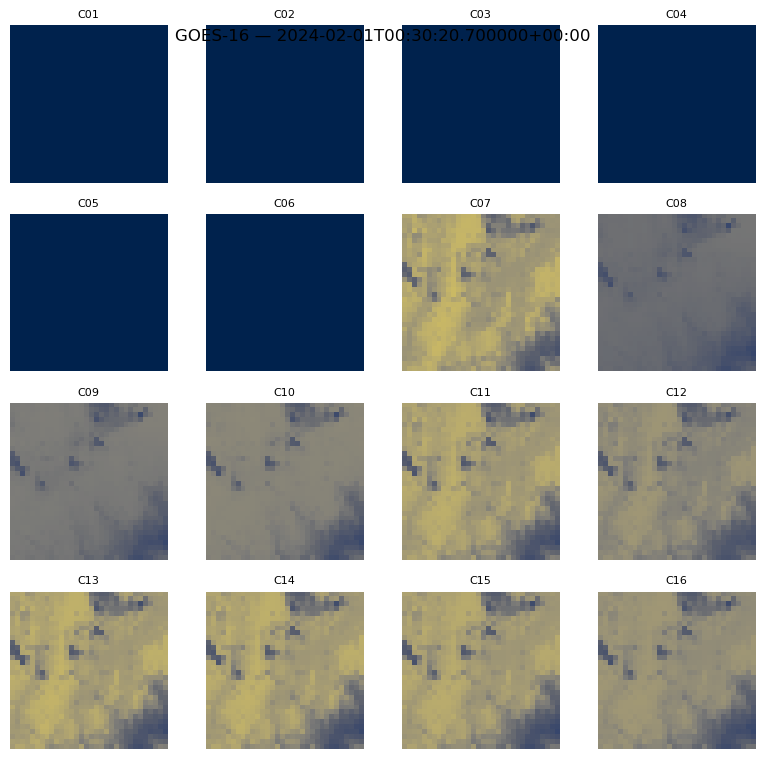

In [12]:
first_ts = sat_raw.index[0]
X0 = np.stack([sat_raw.loc[first_ts, str(ch)] for ch in CHANNELS], axis=0)  # (16,32,32)

fig_mosaic, axes = plt.subplots(4,4, figsize=(8,8))
for i, ax in enumerate(axes.ravel(), start=1):
    ax.imshow(X0[i-1], vmin=0, vmax=1, cmap="cividis")
    ax.set_title(f"C{i:02d}", fontsize=8)
    ax.axis("off")
fig_mosaic.suptitle(f"GOES-16 — {first_ts.isoformat()}", y=0.92)
plt.tight_layout(); plt.show()

fig_mosaic.savefig(OUT_DIR / "mosaic_c01_c16.png", dpi=180)

In [13]:
nc_demo = FILES[0]
ds_demo = xr.open_dataset(nc_demo)

sat_h = float(ds_demo["goes_imager_projection"].perspective_point_height)
x = ds_demo["x"].values * sat_h
y = ds_demo["y"].values * sat_h

Xc, Yc = lonlat_to_geos_xy(ds_demo, LON, LAT)
ix = int(np.argmin((x - Xc)**2))
iy = int(np.argmin((y - Yc)**2))

half = IN_SIZE // 2
xs = slice(max(ix-half, 0), min(ix+half, x.size))
ys = slice(max(iy-half, 0), min(iy+half, y.size))

var = "CMI_C09" if "CMI_C09" in ds_demo else list(ds_demo.data_vars)[0]
full = ds_demo[var].values
crop = ds_demo[var].isel(x=xs, y=ys).values
ph, pw = crop.shape
if (ph, pw) != (IN_SIZE, IN_SIZE):
    crop = np.pad(crop, ((0, max(0,IN_SIZE-ph)), (0, max(0,IN_SIZE-pw))), mode="edge")
resized = resize_32(crop)

xmin, xmax = x[xs].min(), x[xs].max()
ymin, ymax = y[ys].min(), y[ys].max()

vmin = np.nanpercentile(full, 5)
vmax = np.nanpercentile(full, 95)

In [14]:
gip = ds_demo["goes_imager_projection"]
proj = ccrs.Geostationary(
    central_longitude=float(gip.longitude_of_projection_origin),
    satellite_height=float(gip.perspective_point_height),
    sweep_axis=str(gip.sweep_angle_axis)
)

import matplotlib.patches as mpatches
fig_map = plt.figure(figsize=(14,4))

<Figure size 1400x400 with 0 Axes>

In [15]:
# 1) Escena completa + rectángulo ROI
ax1 = fig_map.add_subplot(1,3,1, projection=proj)
ax1.imshow(full, extent=(x.min(), x.max(), y.min(), y.max()),
            transform=proj, origin="upper", vmin=vmin, vmax=vmax, cmap="cividis")
ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax1.add_feature(cfeature.BORDERS, linewidth=0.6)
ax1.add_patch(mpatches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                    fill=False, edgecolor="red", linewidth=2, transform=proj))
ax1.set_title("Escena completa + ROI"); ax1.axis("off")

# 2) Recorte 224×224
ax2 = fig_map.add_subplot(1,3,2, projection=proj)
ax2.imshow(crop, extent=(xmin, xmax, ymin, ymax),
            transform=proj, origin="upper", cmap="cividis")
ax2.set_title("Recorte (224×224)"); ax2.axis("off")

# 3) Reescala 32×32
ax3 = fig_map.add_subplot(1,3,3)
ax3.imshow(resized, cmap="cividis")
ax3.set_title("Reescala (32×32)"); ax3.axis("off")

plt.tight_layout(); plt.show()
fig_map.savefig(OUT_DIR / "full_roi_crop_rescale.png", dpi=180)

ds_demo.close()

<Figure size 640x480 with 0 Axes>

### Diagnosis

Cobertura por canal (features *_mean):


,coverage
C01_mean,1.000000
C03_mean,1.000000
C04_mean,1.000000
C05_mean,1.000000
C06_mean,1.000000
C12_mean,1.000000
C11_mean,1.000000
C09_mean,1.000000
C13_mean,1.000000
C08_mean,0.996667


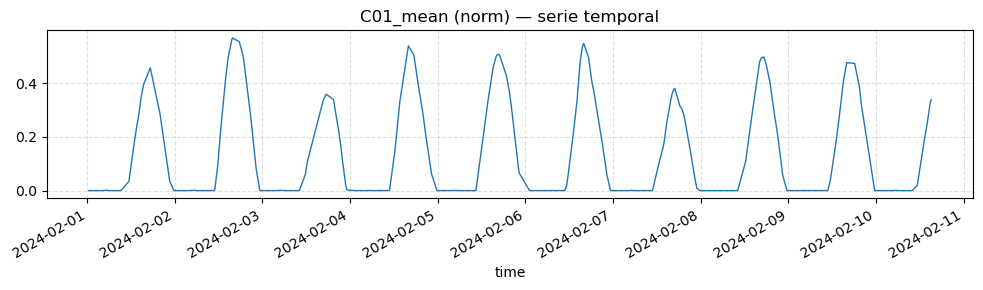

<Figure size 640x480 with 0 Axes>

In [16]:
mean_cols = [c for c in sat_feat.columns if c.endswith("_mean")]
cover = pd.Series({c: sat_feat[c].notna().mean() for c in mean_cols}).sort_values(ascending=False)
print("Cobertura por canal (features *_mean):")
display(cover.to_frame("coverage").head(10))

best_mean = cover.index[0] if len(cover) else None
if best_mean and sat_feat[best_mean].dropna().shape[0] > 0:
    ax = sat_feat[best_mean].dropna().plot(figsize=(10,3), lw=1.0,
                                           title=f"{best_mean} (norm) — serie temporal")
    ax.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()
    plt.gcf().savefig(OUT_DIR / "ts_best_mean.png", dpi=180)
else:
    print("No hay series válidas para graficar (todo NaN).")

### Export

In [17]:
year = sat_raw.index[0].year

full_grid = pd.date_range(f"{year}-01-01 00:00:00", f"{year}-12-31 23:50:00", freq="10min", tz="UTC")

df_join = pd.DataFrame(index=full_grid).join(sat_raw, how="left")

# Alias 0..15 (si fuera necesario para compatibilidad)
for i in range(16):
    src, dst = str(i+1), str(i)
    if src in df_join.columns and dst not in df_join.columns:
        df_join[dst] = df_join[src]

out_pkl = OUT_DIR / "datos_sateli.pkl"
df_join.to_pickle(out_pkl)
print("✅ Guardado (formato legado):", out_pkl, "| shape:", df_join.shape)

✅ Guardado (formato legado): ../data_interim/goes_dataset/datos_sateli.pkl | shape: (52704, 17)
